In [93]:
# Import data science essentials
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import copy
from numpy import matlib
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt

# Import plotting essentials
#import matplotlib.pyplot as plt

#from Config.api_key import coin_key

from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json

url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/ohlcv/historical'
parameters = {
  'id':'1,1027',
  'time_start':'2021-09-10',
  'time_end': '2021-10-09',
  'convert':'USD'
}
headers = {
  'Accepts': 'application/json',
  'X-CMC_PRO_API_KEY': coin_key,
}

session = Session()
session.headers.update(headers)

try:
  response = session.get(url, params=parameters)
  data = json.loads(response.text)
  json_formatted_str = json.dumps(data, indent=2)
  #print(json_formatted_str)
except (ConnectionError, Timeout, TooManyRedirects) as e:
  print(e)


In [94]:
btc_arr = []
for x in range(len(data['data']['1']['quotes'])):
    #print(data['data']['1']['quotes'][x]['quote']['USD']['close'])
    btc_arr.append(data['data']['1']['quotes'][x]['quote']['USD']['close'])
    
print(btc_arr)

[45201.45898324, 46063.27035709, 44963.07263282951, 47092.49383326693, 48176.34639274429, 47783.35780464393, 47267.52002306911, 48278.36351532978, 47260.21733146774, 42843.80244093855, 40693.67719158998, 43574.50943280896, 44895.09660157076, 42839.75169596445, 42716.59314672847, 43208.53910453539, 42235.73184664342, 41034.54466522939, 41564.36348149087, 43790.89562548486, 48116.941218027736, 47711.48646346977, 48199.95155726554, 49112.90128239323, 51514.814060276665, 55361.44942960792, 53805.98516429891, 53967.84676725268]


In [124]:
btc_df = pd.DataFrame(btc_arr)
btc_df.to_csv('api_btc.csv',index=False)

btc_file = "api_btc.csv"
eth_file = "api_eth.csv"

btc_df = pd.read_csv(btc_file)
eth_df = pd.read_csv(eth_file)

btc_df

,0
0,45201.458983
1,46063.270357
2,44963.072633
3,47092.493833
4,48176.346393
5,47783.357805
6,47267.520023
7,48278.363515
8,47260.217331
9,42843.802441


In [96]:
eth_arr = []
for x in range(len(data['data']['1027']['quotes'])):
    #print(data['data']['1']['quotes'][x]['quote']['USD']['close'])
    eth_arr.append(data['data']['1027']['quotes'][x]['quote']['USD']['close'])
    
print(eth_arr)

[3270.27812481, 3410.13459276, 3285.511766263861, 3429.169636597516, 3615.282616378894, 3571.2949350055046, 3398.538777821521, 3432.018234624032, 3329.447894898392, 2958.993504728316, 2764.431130864969, 3077.867980527073, 3155.5237338611523, 2931.669216719692, 2925.565608690162, 3062.2653558037177, 2934.1387982985507, 2807.2967397712478, 2853.1433729158744, 3001.679051738826, 3307.5160778952013, 3391.694346949812, 3418.3586596174073, 3380.089200379371, 3518.518517366793, 3580.562049118014, 3587.974768107968, 3563.7592193153064]


In [122]:
eth_df = pd.DataFrame(eth_arr)
eth_df.to_csv('api_eth.csv',index=False)

In [98]:
spread_btc = btc_df
spread_eth = eth_df

In [99]:
# Were finally ready to start implementing the pair trade model! 

# First set an arbitrary lookback window and introduce bias into the model. Ideally we should use a quantitative
# method to approximate this, but again no time. Ornstein–Uhlenbeck formula is a good choice to estimate half-life
# of mean reversion, however again, no time.

# Possibly could use a Data Science approach like a grid search or something and filter results for highest returns
# but thats a fantastic way to introduce over-fitting. I personally find quantitative approaches more comforting.
lookback=7

# Pre-allocate hedgeRatio array
hedgeRatio=np.empty(len(spread_btc))
hedgeRatio[:]=np.nan

# Use for loop, lookback window, and OLS to estimate hedgeRatio (BTC-hedgeRatio*ETH)
for t in range(lookback,len(hedgeRatio),1):
    
    regression_result=sm.OLS(spread_btc[t-lookback:t],spread_eth[t-lookback:t]).fit()
    hedgeRatio[t]=regression_result.params[0]

In [100]:
# y2 = [independent_spread dependent_spread]

# Create array to store prices for ETH and BTC
y2 = np.array([spread_eth, spread_btc]).transpose()

# introducing massive amounts of look-ahead bias :)
hedgeRatio_df = pd.DataFrame(hedgeRatio,columns=['Hedge Ratio'])
hedgeRatio_df.fillna(method='bfill',inplace=True)
hedgeRatio_df['Ones'] = np.ones(len(spread_btc))
hedgeRatio1 = copy.deepcopy(hedgeRatio_df)

hedgeRatio1

,Hedge Ratio,Ones
0,13.611561,1.0
1,13.611561,1.0
2,13.611561,1.0
3,13.611561,1.0
4,13.611561,1.0
5,13.611561,1.0
6,13.611561,1.0
7,13.611561,1.0
8,13.648946,1.0
9,13.741837,1.0


In [101]:
# For next step we need the negative of the hedgeRatio so...
hedgeRatio1['Hedge Ratio'] = hedgeRatio1['Hedge Ratio']*-1.0
y2[0]

array([[ 3270.27812481, 45201.45898324],
       [ 3410.13459276, 46063.27035709],
       [ 3285.51176626, 44963.07263283],
       [ 3429.1696366 , 47092.49383327],
       [ 3615.28261638, 48176.34639274],
       [ 3571.29493501, 47783.35780464],
       [ 3398.53877782, 47267.52002307],
       [ 3432.01823462, 48278.36351533],
       [ 3329.4478949 , 47260.21733147],
       [ 2958.99350473, 42843.80244094],
       [ 2764.43113086, 40693.67719159],
       [ 3077.86798053, 43574.50943281],
       [ 3155.52373386, 44895.09660157],
       [ 2931.66921672, 42839.75169596],
       [ 2925.56560869, 42716.59314673],
       [ 3062.2653558 , 43208.53910454],
       [ 2934.1387983 , 42235.73184664],
       [ 2807.29673977, 41034.54466523],
       [ 2853.14337292, 41564.36348149],
       [ 3001.67905174, 43790.89562548],
       [ 3307.5160779 , 48116.94121803],
       [ 3391.69434695, 47711.48646347],
       [ 3418.35865962, 48199.95155727],
       [ 3380.08920038, 49112.90128239],
       [ 3518.51

In [102]:
# Calculating unit portfolio price using hedgeRatio and ETH-BTC prices
yport = np.sum(np.multiply(hedgeRatio1,y2[0]),axis=1)
yport

0      687.870427
1     -353.982975
2      242.130444
3      416.143851
4    -1033.291674
5     -827.539276
6     1008.103828
7     1563.239668
8     1816.763599
9     2181.794983
10    2463.400292
11     690.563453
12     494.442879
13    1155.993781
14     816.466975
15    -907.151446
16     -13.806077
17     644.832292
18     548.613554
19     461.427424
20     182.923823
21   -1419.211027
22   -1013.990170
23     488.589041
24     820.699484
25    3714.379386
26    1506.338335
27    1795.627484
dtype: float64

In [103]:
# Convert unit portfolio to df
yport_df = pd.DataFrame(yport)
yport_df

,0
0,687.870427
1,-353.982975
2,242.130444
3,416.143851
4,-1033.291674
5,-827.539276
6,1008.103828
7,1563.239668
8,1816.763599
9,2181.794983


In [104]:
# For Linear Mean Reversion strategy we scale into the position as the unit portfolio
# deviates further from its mean. Anticipating mean reversion we unload the position and capture a profit....
# at least theoretically.
zScore=-(yport_df-yport_df.rolling(window=lookback).mean())/yport_df.rolling(window=lookback).std()

# This backfill introduces look-ahead bias but I had to deal with the nan somehow. In a production model this
# is certainly a no no.
zScore.fillna(method='bfill',inplace=True)
zScore.head(20)

,0
0,-1.276400
1,-1.276400
2,-1.276400
3,-1.276400
4,-1.276400
5,-1.276400
6,-1.276400
7,-1.491881
8,-1.234900
9,-1.140457


In [105]:
# Had to create a deep copy since y2 is overwritten when calculating positions. IDK why that happens though.
y3 = copy.deepcopy(y2[0])
y3

array([[ 3270.27812481, 45201.45898324],
       [ 3410.13459276, 46063.27035709],
       [ 3285.51176626, 44963.07263283],
       [ 3429.1696366 , 47092.49383327],
       [ 3615.28261638, 48176.34639274],
       [ 3571.29493501, 47783.35780464],
       [ 3398.53877782, 47267.52002307],
       [ 3432.01823462, 48278.36351533],
       [ 3329.4478949 , 47260.21733147],
       [ 2958.99350473, 42843.80244094],
       [ 2764.43113086, 40693.67719159],
       [ 3077.86798053, 43574.50943281],
       [ 3155.52373386, 44895.09660157],
       [ 2931.66921672, 42839.75169596],
       [ 2925.56560869, 42716.59314673],
       [ 3062.2653558 , 43208.53910454],
       [ 2934.1387983 , 42235.73184664],
       [ 2807.29673977, 41034.54466523],
       [ 2853.14337292, 41564.36348149],
       [ 3001.67905174, 43790.89562548],
       [ 3307.5160779 , 48116.94121803],
       [ 3391.69434695, 47711.48646347],
       [ 3418.35865962, 48199.95155727],
       [ 3380.08920038, 49112.90128239],
       [ 3518.51

In [106]:
hedgeRatio2 = copy.deepcopy(hedgeRatio_df)
# Preparing hedgeRatio df for calculating daily position sizes in next cell
hedgeRatio2['Ones'] = hedgeRatio2['Ones']*-1.0
hedgeRatio2

,Hedge Ratio,Ones
0,13.611561,-1.0
1,13.611561,-1.0
2,13.611561,-1.0
3,13.611561,-1.0
4,13.611561,-1.0
5,13.611561,-1.0
6,13.611561,-1.0
7,13.611561,-1.0
8,13.648946,-1.0
9,13.741837,-1.0


In [107]:
# Positions array for Linear Mean Reversion Strategy
positions = np.multiply(matlib.repmat(zScore,1,2),hedgeRatio2,y2[0])
positions

array([[-17.37379896,   1.27640023],
       [-17.37379896,   1.27640023],
       [-17.37379896,   1.27640023],
       [-17.37379896,   1.27640023],
       [-17.37379896,   1.27640023],
       [-17.37379896,   1.27640023],
       [-17.37379896,   1.27640023],
       [-20.30683516,   1.49188149],
       [-16.85508496,   1.23490013],
       [-15.67197329,   1.1404569 ],
       [-14.07378839,   1.01767557],
       [  7.25913556,  -0.52100292],
       [ 18.05879956,  -1.28342639],
       [  6.248366  ,  -0.43945515],
       [ 10.2634069 ,  -0.71661527],
       [ 24.2477898 ,  -1.68314642],
       [  9.50882078,  -0.66036698],
       [ -4.93180331,   0.34278618],
       [ -3.3608315 ,   0.23378663],
       [ -1.60683934,   0.11131491],
       [  1.61432436,  -0.1113907 ],
       [ 24.64198021,  -1.70113736],
       [ 16.44227809,  -1.14206669],
       [ -8.61956547,   0.5991838 ],
       [-13.48770274,   0.93613888],
       [-28.28640882,   1.9610259 ],
       [ -7.65218187,   0.52497172],
 

In [108]:
# Calculating Daily Profit and Loss
# This is as simple as multiplying the position size times the calculated returns using y3

pnl_arr = [0]
    
for i in range(1,y3.shape[0]):
    
    # Calculate pnl for independent variable (ETH)
    independent_return = positions[i-1,0]*((y3[i,0]-y3[i-1,0])/y3[i-1,0])
    
    # Calcualate pnl for dependent variable (BTC)
    dependent_return = positions[i-1,1]*(y3[i,1]-y3[i-1,1])/y3[i-1,1]
    
    # Compute daily_pnl by summing pnl for independent and dependent variable
    daily_pnl = independent_return+dependent_return
        
    pnl_arr.append(daily_pnl)


In [109]:
pnl_df = pd.DataFrame(pnl_arr,columns=['Daily PnL'])
positions_df = pd.DataFrame(positions,columns=['ETH Position','BTC Position'])

In [110]:
# temp_df is calculating the gross market value of the portfolio in preparation for returns in next cell
temp_df = positions_df.shift(1).abs().sum(axis=1)
temp_df

0      0.000000
1     18.650199
2     18.650199
3     18.650199
4     18.650199
5     18.650199
6     18.650199
7     18.650199
8     21.798717
9     18.089985
10    16.812430
11    15.091464
12     7.780138
13    19.342226
14     6.687821
15    10.980022
16    25.930936
17    10.169188
18     5.274589
19     3.594618
20     1.718154
21     1.725715
22    26.343118
23    17.584345
24     9.218749
25    14.423842
26    30.247435
27     8.177154
dtype: float64

In [111]:
# Computing daily returns
ret_df = pnl_df['Daily PnL'].div(temp_df)
ret_df

0          NaN
1    -0.038534
2     0.032409
3    -0.037491
4    -0.048984
5     0.010776
6     0.044324
7    -0.007713
8     0.026398
9     0.097291
10    0.057888
11   -0.100962
12    0.021511
13   -0.063196
14   -0.001756
15    0.042925
16   -0.037663
17   -0.038576
18   -0.014431
19   -0.045190
20   -0.088887
21    0.024352
22    0.006693
23   -0.011698
24   -0.035114
25   -0.011643
26   -0.003758
27    0.006509
dtype: float64

In [112]:
# Computing cumulative returns. I'm so glad pandas has functions built in for this!
cumulative_ret = ret_df[1:].add(1).cumprod().sub(1)
cumulative_ret

1    -0.038534
2    -0.007374
3    -0.044588
4    -0.091388
5    -0.081597
6    -0.040890
7    -0.048287
8    -0.023165
9     0.071873
10    0.133922
11    0.019439
12    0.041368
13   -0.024442
14   -0.026155
15    0.015647
16   -0.022606
17   -0.060309
18   -0.073870
19   -0.115722
20   -0.194323
21   -0.174704
22   -0.169180
23   -0.178899
24   -0.207731
25   -0.216955
26   -0.219898
27   -0.214820
dtype: float64

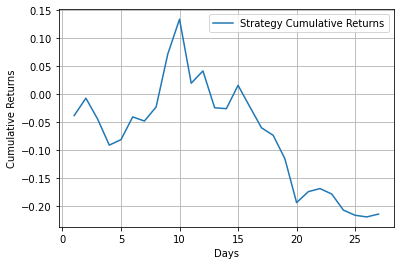

In [130]:
# Plotting cumulative returns
plt.plot(cumulative_ret,label='Strategy Cumulative Returns')
plt.xlabel('Days')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.legend()
plt.savefig('../static/img/test_results.png',facecolor='white')
plt.show()